In [8]:
import warnings 
warnings.filterwarnings('ignore')

# for data analytics
import pandas as pd
import numpy as np
from collections import Counter

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# imblean provides tools for us to deal with imbalanced class sizes
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# machine learning models
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# for evaluation of machine learning models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix


## Read data

In [10]:
X_train = pd.read_csv('../datasets/word2vec/train_data_imputed_FINAL.csv')
X_test = pd.read_csv('../datasets/word2vec/test_data_imputed_FINAL.csv')
y_train = pd.read_csv('../datasets/word2vec/y_train_FINAL.csv').iloc[:,1:]
y_test = pd.read_csv('../datasets/word2vec/y_test_FINAL.csv').iloc[:,1:]

## Oversampling

In [3]:
print(X_train.shape)
print(y_train.shape)

(11516, 263)
(11516, 1)


In [4]:
def SMOTE_ENN(X_train, y_train, n_neighbours, k_neighbours, sampling_strategy):
    # SMOTE ENN oversampling
    smote_only = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors = k_neighbours)
    ennObj = EditedNearestNeighbours(n_neighbors=n_neighbours)
    smote_enn = SMOTEENN(random_state=42, smote=smote_only , enn= ennObj)
    X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
    return X_res_smoteENN, y_res_smoteENN

X_res_smoteENN, y_res_smoteENN = SMOTE_ENN(X_train, y_train, n_neighbours = 4, k_neighbours = 6, sampling_strategy = 0.1)

## SVM

#### Tuning (RBF)

In [5]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import loguniform
from sklearn.svm import SVC

# RandomizedSearchCV
classifier = SVC(kernel = 'rbf', random_state = 42, probability = True)
distributions = dict(C= loguniform(1e0, 1e5), gamma = loguniform(1e-5, 1e-0))
clf = RandomizedSearchCV(classifier, distributions, random_state = 42)
clf.fit(X_res_smoteENN, y_res_smoteENN)

print(f'Best Parameters: {clf.best_params_}')
print(f'Best Estimator: {clf.best_estimator_}')
print(f'Mean CV Score: {clf.best_score_}')

Best Parameters: {'C': 4570.563099801452, 'gamma': 0.009846738873614563}
Best Estimator: SVC(C=4570.563099801452, gamma=0.009846738873614563, probability=True,
    random_state=42)
Mean CV Score: 0.999421419273725


In [6]:
clf.best_estimator_.fit(X_res_smoteENN, y_res_smoteENN)
y_pred = clf.best_estimator_.predict(X_test)

In [7]:
from sklearn import metrics
print('-----  METRICS -----')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'F1: {metrics.f1_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n {metrics.confusion_matrix(y_test, y_pred)}')

-----  METRICS -----
Accuracy: 0.9954861111111111
Precision: 0.8909090909090909
Recall: 0.875
F1: 0.8828828828828829
Confusion Matrix:
 [[2818    6]
 [   7   49]]


In [8]:
y_pred_train = clf.best_estimator_.predict(X_res_smoteENN)

In [9]:
from sklearn import metrics
print('-----  METRICS -----')
print(f'Accuracy: {metrics.accuracy_score(y_res_smoteENN, y_pred_train)}')
print(f'Precision: {metrics.precision_score(y_res_smoteENN, y_pred_train)}')
print(f'Recall: {metrics.recall_score(y_res_smoteENN, y_pred_train)}')
print(f'F1: {metrics.f1_score(y_res_smoteENN, y_pred_train)}')
print(f'Confusion Matrix:\n {metrics.confusion_matrix(y_res_smoteENN, y_pred_train)}')

-----  METRICS -----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Confusion Matrix:
 [[10968     0]
 [    0  1129]]


#### SHAP
https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [92]:
import shap
# Fits the explainer
explainer = shap.Explainer(clf.best_estimator_.predict, X_test)

In [93]:
# Calculates the SHAP values: Takes LONG to run. Open SHAP values pkl file instead.
shap_values = explainer(X_test)

Permutation explainer: 2881it [3:00:23,  3.63s/it]                            


##### To store SHAP results

In [110]:
# import pickle
# # Open a file and use dump()
# with open('shap_values.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(shap_values, file)


In [19]:
import pickle
#Open the file in binary mode
with open('shap_values.pkl', 'rb') as file:
      
    # Call load method to deserialze
    shap_values = pickle.load(file)
  
    print(shap_values)

.values =
array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.005,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   , -0.005],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

.base_values =
array([0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02])

.data =
array([[ 0.        ,  0.        ,  0.        , ...,  0.04350895,
         0.12092303,  0.47053942],
       [ 0.        ,  0.        ,  0.        , ...,  0.05552163,
         0.01442693,  0.8619563 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.23731853,
         0.566246  , -0.00953739],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.19111875,
         0.45762622, -0.13306627],
       [ 0.        ,  0.        ,  0.        , ..., -0.61065596,
         0.28271505,  0.2784445 ],
       [ 0.        

##### Standard SHAP values

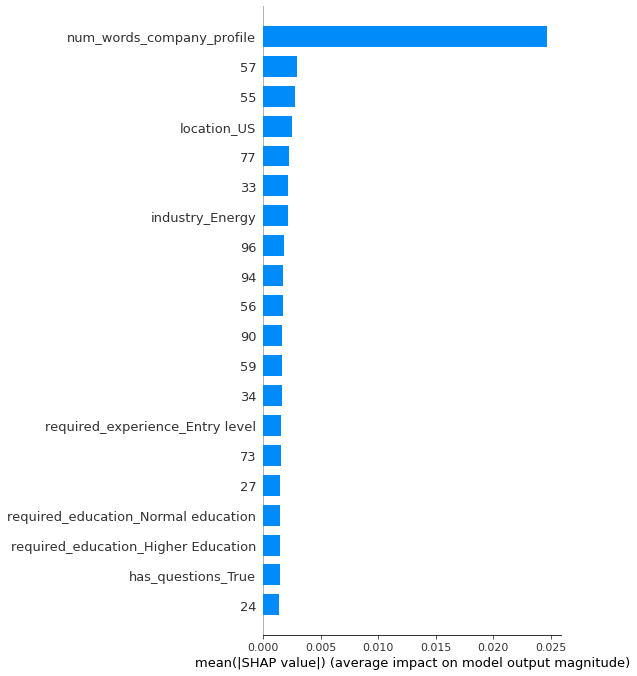

In [29]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

##### Sum up SHAP values for categorical variables

In [4]:
listt = []
for i in range(100):
    listt.append(1)

n_categories = [77,2,2,2,6,8,7, 20, 36, 2, 1]
n_categories.extend(listt)

sum(n_categories)

263

In [7]:
import numpy as np
new_shap_values = []
for values in shap_values.values:
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))[:-1]
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

In [11]:
non_encoded = pd.read_csv('word2vec/test_data_not_encoded.csv').iloc[:,1:]
non_encoded[X_test.iloc[:,163:].columns] = X_test.iloc[:,163:]

In [12]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(non_encoded)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(non_encoded.columns)

##### Summary plots

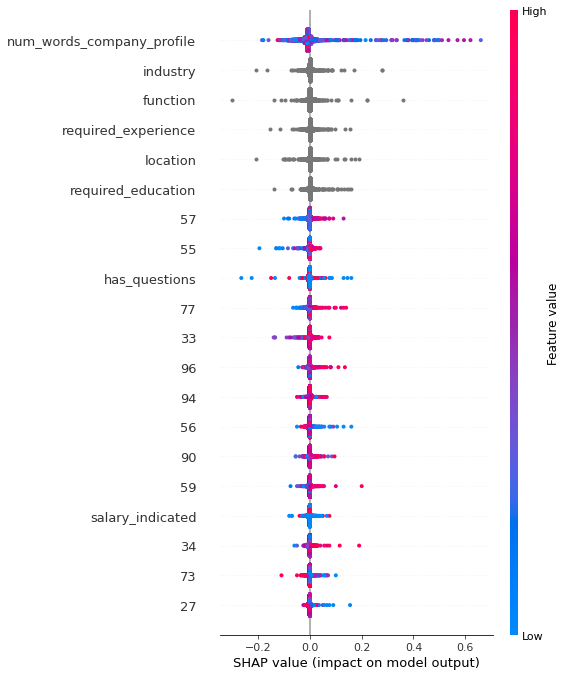

In [14]:
import shap
shap.summary_plot(shap_values)

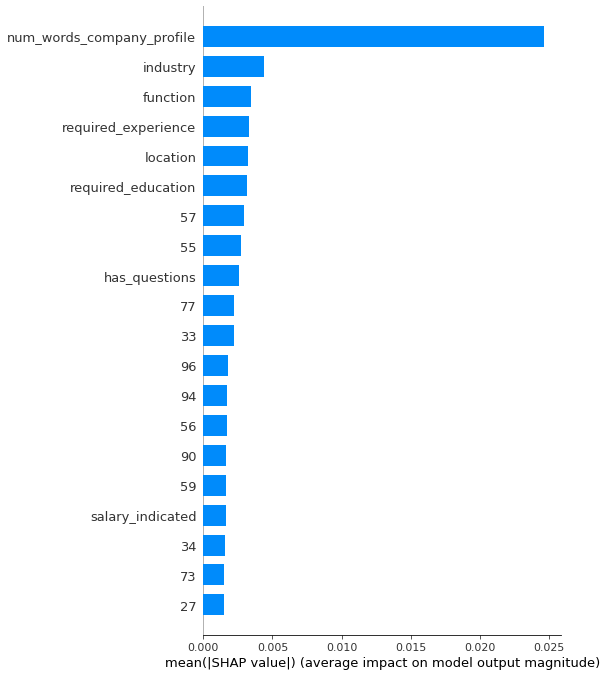

In [15]:
shap.summary_plot(shap_values, non_encoded, plot_type = "bar")

##### Individual predictions

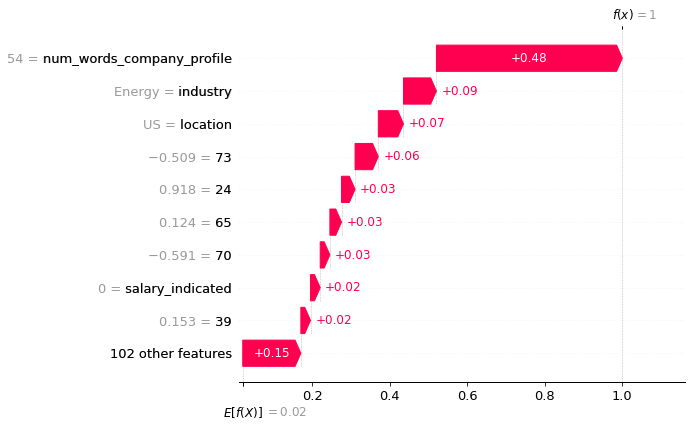

In [16]:
shap.plots.waterfall(shap_values[53])

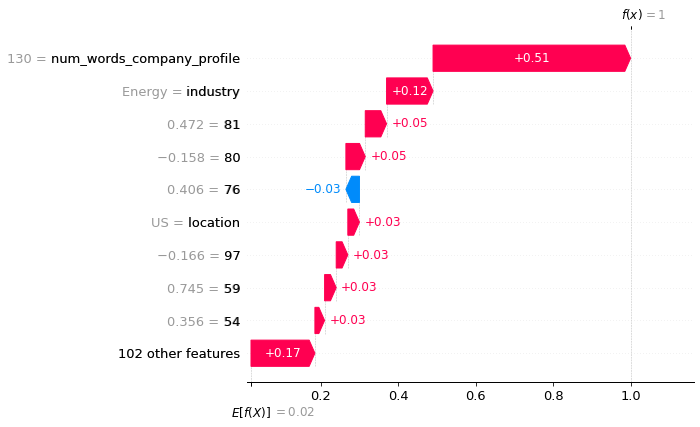

In [281]:
shap.plots.waterfall(shap_values[2619])

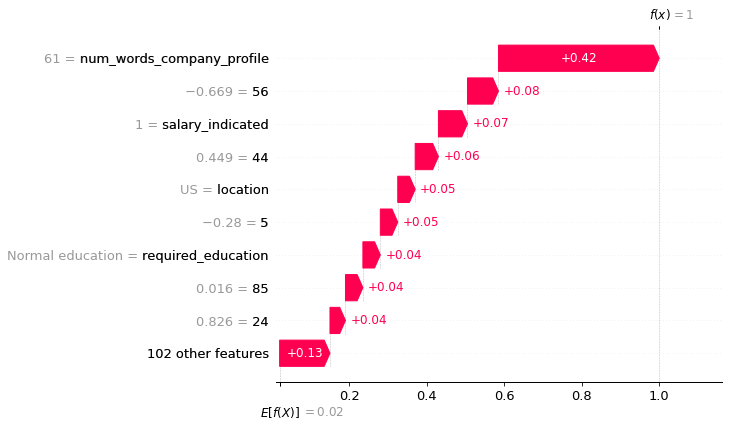

In [284]:
shap.plots.waterfall(shap_values[2839])

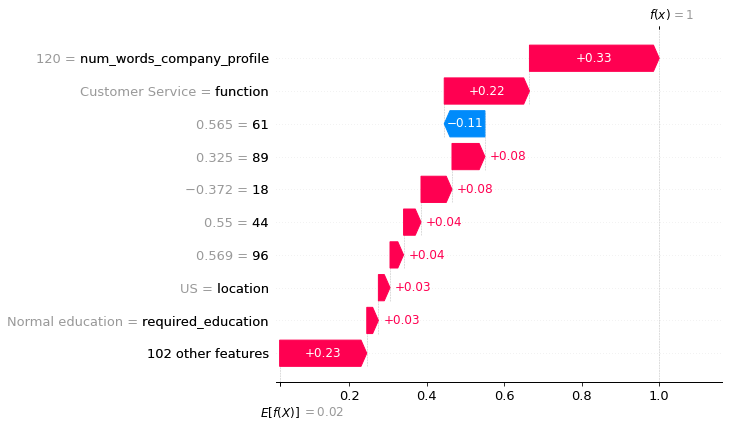

In [288]:
shap.plots.waterfall(shap_values[1500])

##### Analysis for each cat variable

In [385]:
#get shaply values and data
values = shap_values[:,"industry"].values
data = shap_values[:,"industry"].data

#split odor shap values based on odor category
categories = list(set(data))

groups = []
for o in categories:
    relevant_values = values[data == o]
    groups.append(relevant_values)

means = []
for i in groups:
    means.append(np.mean(i))

Text(0.5, 1.0, 'Mean SHAP Values across Industries')

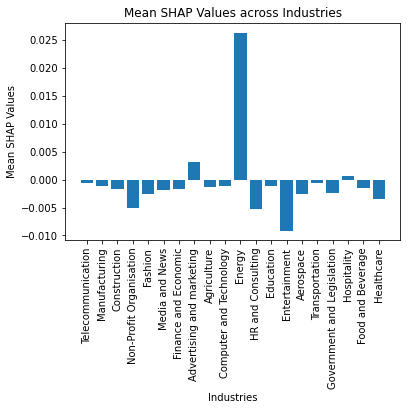

In [388]:
plt.bar(categories[1:],means[1:])
plt.xticks(rotation = 90)
plt.ylabel('Mean SHAP Values')
plt.xlabel('Industries')
plt.title('Mean SHAP Values across Industries')

In [390]:
#get shaply values and data
values = shap_values[:,"function"].values
data = shap_values[:,"function"].data

#split odor shap values based on odor category
categories = list(set(data))

groups = []
for o in categories:
    relevant_values = values[data == o]
    groups.append(relevant_values)

means = []
for i in groups:
    means.append(np.mean(i))

Text(0.5, 1.0, 'Mean SHAP Values across Functions')

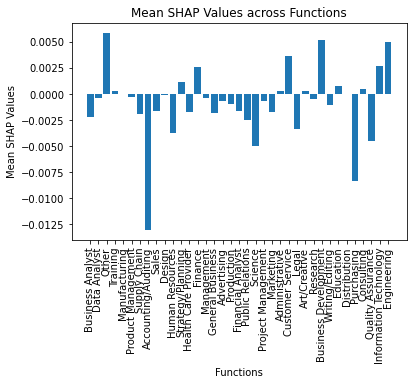

In [391]:
plt.bar(categories[1:],means[1:])
plt.xticks(rotation = 90)
plt.ylabel('Mean SHAP Values')
plt.xlabel('Functions')
plt.title('Mean SHAP Values across Functions')

In [393]:
#get shaply values and data
values = shap_values[:,"required_experience"].values
data = shap_values[:,"required_experience"].data

#split odor shap values based on odor category
categories = list(set(data))

groups = []
for o in categories:
    relevant_values = values[data == o]
    groups.append(relevant_values)

means = []
for i in groups:
    means.append(np.mean(i))

Text(0.5, 1.0, 'Mean SHAP Values across Required Experiences')

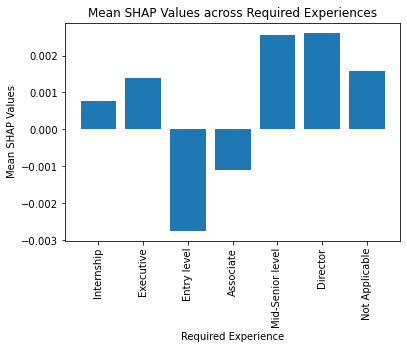

In [394]:
plt.bar(categories[1:],means[1:])
plt.xticks(rotation = 90)
plt.ylabel('Mean SHAP Values')
plt.xlabel('Required Experience')
plt.title('Mean SHAP Values across Required Experiences')

In [395]:
#get shaply values and data
values = shap_values[:,"required_education"].values
data = shap_values[:,"required_education"].data

#split odor shap values based on odor category
categories = list(set(data))

groups = []
for o in categories:
    relevant_values = values[data == o]
    groups.append(relevant_values)

means = []
for i in groups:
    means.append(np.mean(i))

Text(0.5, 1.0, 'Mean SHAP Values across Required Education Levels')

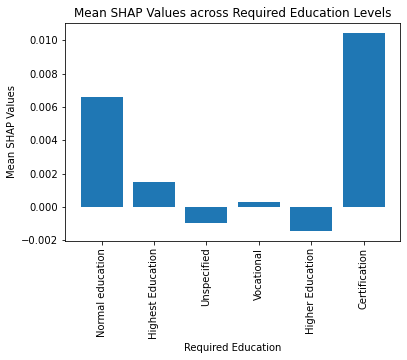

In [396]:
plt.bar(categories[1:],means[1:])
plt.xticks(rotation = 90)
plt.ylabel('Mean SHAP Values')
plt.xlabel('Required Education')
plt.title('Mean SHAP Values across Required Education Levels')

In [378]:
#get shaply values and data
values = shap_values[:,"location"].values
data = shap_values[:,"location"].data

#split odor shap values based on odor category
categories = list(set(data))

groups = []
for o in categories:
    relevant_values = values[data == o]
    groups.append(relevant_values)

means = []
for i in groups:
    means.append(np.mean(i))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61],
 <a list of 62 Text major ticklabel objects>)

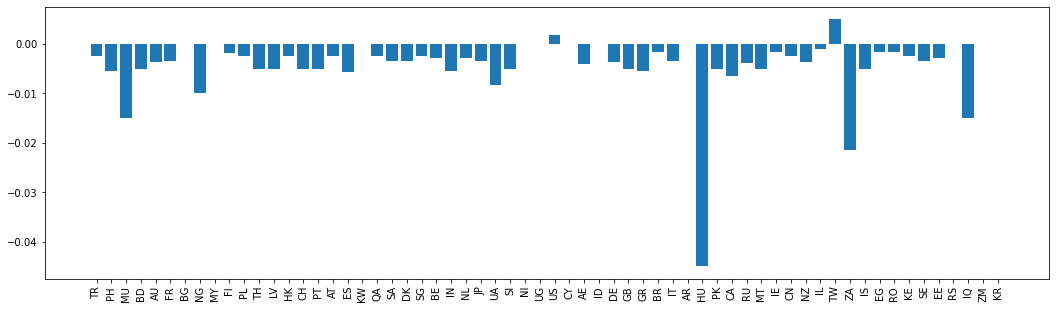

In [381]:
plt.figure(figsize = (18, 5))
plt.bar(categories[1:],means[1:])
plt.xticks(rotation = 90)